# Figure 6: Seasonal trends
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

In [4]:
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

## ERA-Interim and ERA5
Downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/ecv-for-climate-change?tab=doc (there are correction but doesn't seem to affect HMA)

For Snow Cover Extent, there is only ERA-Interim on the period 1979-2014 and is computed from snow depth (Appendix A : https://tc.copernicus.org/articles/13/2221/2019/) and https://confluence.ecmwf.int/display/CKB/ERA-Interim%3A+documentation#ERAInterim:documentation-Computationofnear-surfacehumidityandsnowcover

In [5]:
path = '/data/mlalande/ERA-ECV/NETCDF'

In [6]:
tas_era5 = xr.open_dataset(path+'/1month_mean_Global_ea_2t_1979-2014_v02.nc').t2m.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) - 273.15
tas_erai = xr.open_dataset(path+'/1month_mean_Global_ei_t2m_1979-2014_v02.nc').t2m.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) - 273.15
pr_era5 = xr.open_dataset(path+'/1month_mean_Global_ea_tp_1979-2014_v02.nc').tp.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) * 10**3
pr_erai = xr.open_dataset(path+'/1month_mean_Global_ei_tp_1979-2014_v02.nc').tp.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) * 10**3

# Correct time for precipitations
pr_era5['time'] = tas_era5.time
pr_erai['time'] = tas_era5.time

In [7]:
regridder = xe.Regridder(tas_era5, elevation, 'bilinear', periodic=False, reuse_weights=True)

ym_obs_list = []

for obs in [tas_era5, tas_erai, pr_era5, pr_erai]:
    np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)
    obs_regrid = regridder(obs)

    ym_temp = []
    for season in seasons:
        print(season)
        # Make annual mean
        ym = u.year_mean(obs_regrid, calendar='standard', season=season)

        # Compute trends
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
            ym[arr_name] = arr

        ym_temp.append(ym)

    ym_obs_list.append(xr.concat(ym_temp, pd.Index(seasons, name='season')))
    
ym_obs_tas_era5 = ym_obs_list[0]
ym_obs_tas_erai = ym_obs_list[1]
ym_obs_pr_era5 = ym_obs_list[2]
ym_obs_pr_erai = ym_obs_list[3]

Reuse existing file: bilinear_141x241_35x60.nc
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS
DJFMA


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


JJAS


In [8]:
SD = xr.open_mfdataset('/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/sd.*.asmei.GLOBAL_075.nc').sd.sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)
RW = 1000
obs = xr.ufuncs.minimum(1, RW*SD/15)*100

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_regrid = regridder(obs)

ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid.load(), calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs_snc_erai = xr.concat(ym_temp, pd.Index(seasons, name='season'))

Reuse existing file: bilinear_47x80_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


### Temperature

In [9]:
obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_regrid = regridder(obs)

ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid, calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs_tas = xr.concat(ym_temp, pd.Index(seasons, name='season'))

Reuse existing file: bilinear_70x120_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


### Snow Cover

In [10]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

In [11]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

obs_regrid = regridder(obs)

ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid, calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs_snc = xr.concat(ym_temp, pd.Index(seasons, name='season'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_35x60.nc


### Precipitation

#### APHRODITE

In [12]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

obs_regrid = regridder(obs)

ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid.load(), calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs_pr = xr.concat(ym_temp, pd.Index(seasons, name='season'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


#### GPCP

In [13]:
obs_longname = 'GPCP CDR v2.3 (2.5°)'
obs_name = 'GPCP'

obs = xr.open_mfdataset(
    # '/bdd/GPCP/netcdf/surf-rr_gpcp_multi-sat_250d_01mth_*_v2.2-02.nc', combine='by_coords'
    # -> missing some month (ex 2014/11)
    '/data/mlalande/GPCP/CDR_monthly_v2.3/*/gpcp_v02r03_monthly_d*_c20170616.nc'
).precip.sel(time=period, latitude=latlim_ext, longitude=lonlim_ext)

obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

obs_regrid = regridder(obs)

ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid.load(), calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs_pr_GPCP = xr.concat(ym_temp, pd.Index(seasons, name='season'))

Reuse existing file: bilinear_14x24_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Load models
Possible to load results direclty later

In [14]:
list_models = u.get_model_names()
# list_models = list_models[:10]
list_models

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL']

## Load results

In [15]:
list_var = ['tas', 'snc', 'pr']

In [16]:
# model
ym_list = [[None] * (len(list_models)) for i in range(len(list_var))]

for i_var, var in enumerate(list_var):
    
    table = u.get_table(var)
    label, units, levels, cmap, extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    print(label)
    
    # for i, model in enumerate(list_models[:2]):
    for i_model, model in enumerate(list_models):
#         print(model)
        ym_list[i_var][i_model] = xr.open_dataarray('results/ym/'+var+'/'+var+'_'+model+'_historical_ym_trend-bias_197901-201412_HMA.nc')    

Near-Surface Air Temperature
Snow Cover Extent
Total Precipitation


In [17]:
# ym_list[10].realization

## Compute the multimodel mean (for first member)

In [18]:
ensemble_r0_mean = [None]*len(list_var)

for i_var, var in enumerate(list_var):
    ensemble_r0 = xr.concat([ym_list[i_var][i_model].isel(realization=0) for i_model in range(len(list_models))], pd.Index(list_models, name='model'))
    ensemble_r0_mean[i_var] = ensemble_r0.mean('model').isel(year=slice(0,-1))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [28]:
# ensemble_r0_mean[0]

In [19]:
for i_var, var in enumerate(list_var): 
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ensemble_r0_mean[i_var].year, ensemble_r0_mean[i_var], 'year')):
        ensemble_r0_mean[i_var][arr_name] = arr

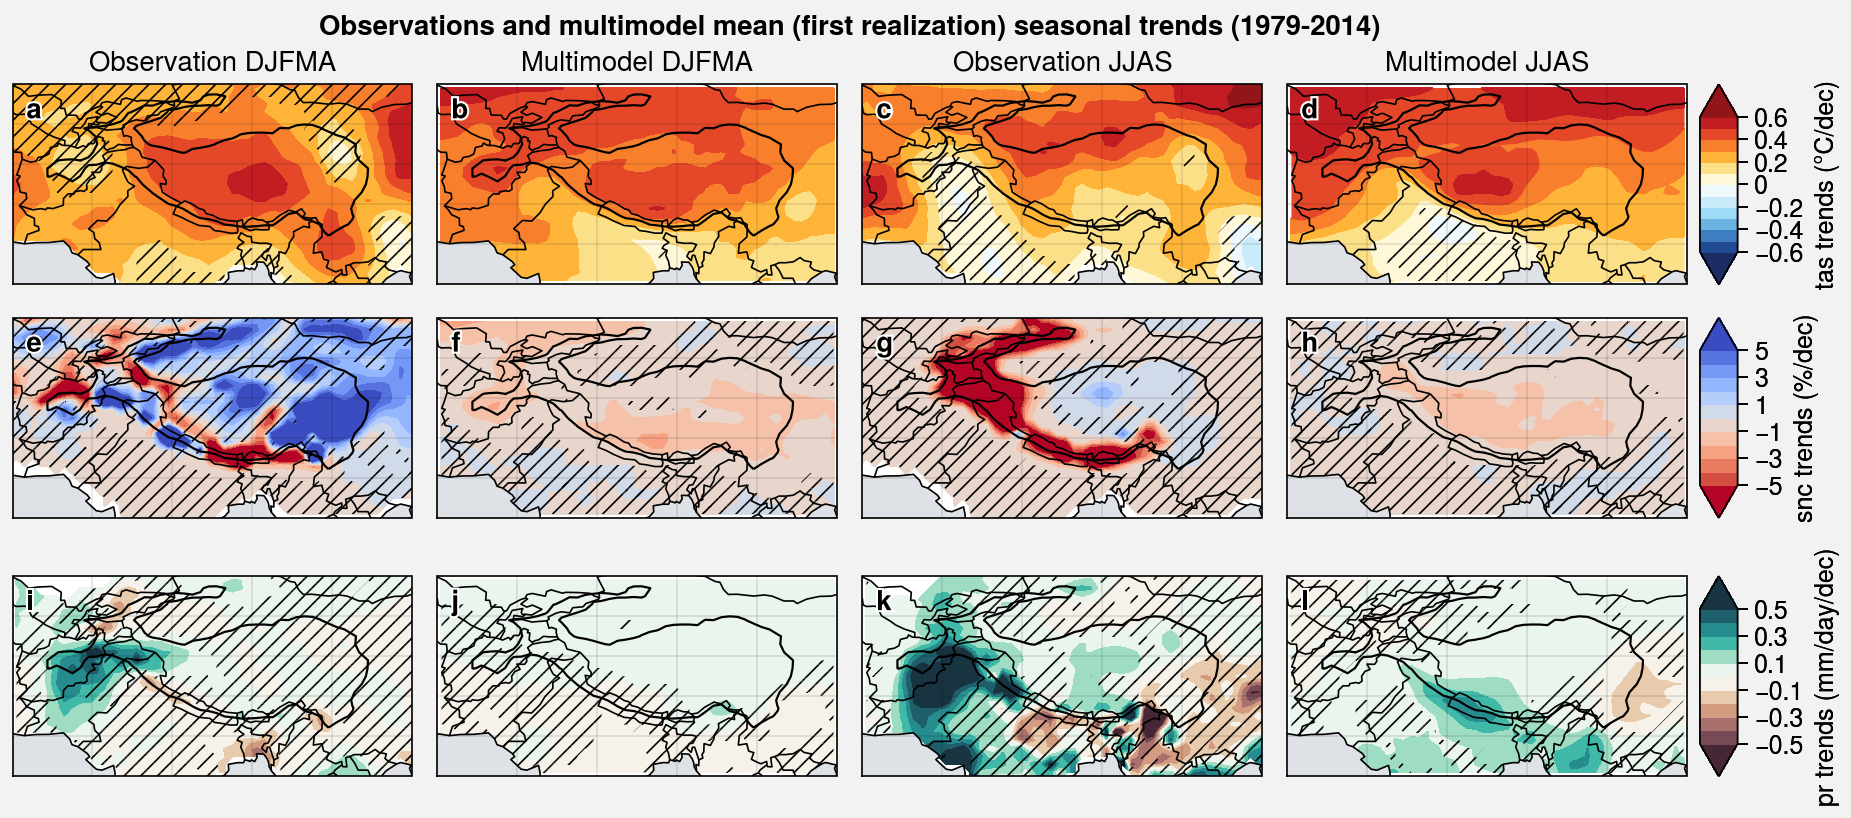

In [21]:
ym_obs_list = [ym_obs_tas, ym_obs_snc, ym_obs_pr]

cmap_list = ['ColdHot', 'CoolWarm_r', 'DryWet']
# cmap_list = ['RdYlBu', 'RdBu_r', 'DryWet']
levels_list = [plot.arange(-0.6,0.6,0.1), plot.arange(-5,5,1), plot.arange(-0.5,0.5,0.1)]
extend_list = ['both', 'both', 'both']

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=len(list_var), axwidth=2)

k = 0
for i_var, var in enumerate(list_var):
    
    label, units, levels, cmap, extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
    for season in seasons:
        
        # Observations
        m = axs[k].contourf(
            ym_obs_list[i_var].sel(season=season).slope*10, cmap=cmap_list[i_var], levels=levels_list[i_var], extend=extend_list[i_var]
        )
        pvalue = ym_obs_list[i_var].sel(season=season).pvalue
        axs[k].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
        if k in range(4):
            axs[k].format(title='Observation ' + season)
        k += 1
    
        # Models
        m = axs[k].contourf(
            ensemble_r0_mean[i_var].sel(season=season).slope*10, cmap=cmap_list[i_var], levels=levels_list[i_var], extend=extend_list[i_var]
        )
        pvalue = ensemble_r0_mean[i_var].sel(season=season).pvalue
        axs[k].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
        if k in range(4):
            axs[k].format(title='Multimodel ' + season)
        k += 1

    axs[k-1].colorbar(m, label=var+' trends ('+units+'/dec)')
    
for ax in axs:
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

axs.format(
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Observations and multimodel mean (first realization) seasonal trends ('+period.start+'-'+period.stop+')',
    abc=True, abcloc='ul'
)

filename = 'fig6_seasonal-trends_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

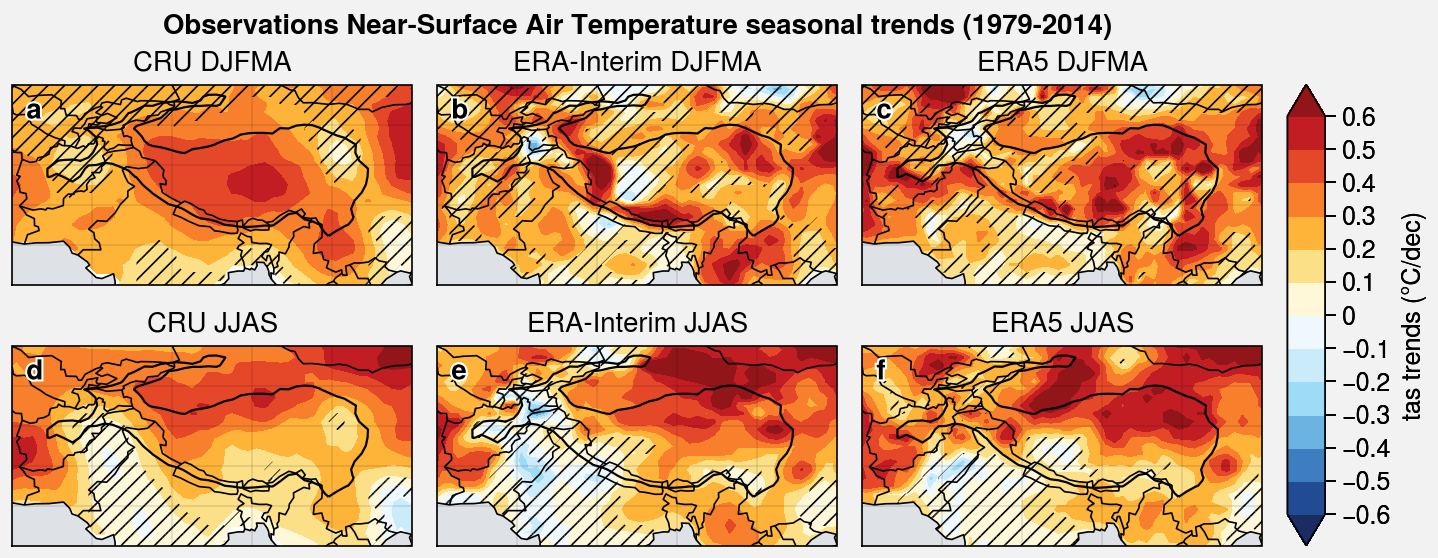

In [22]:
ym_obs_list = [ym_obs_tas, ym_obs_tas_erai, ym_obs_tas_era5]
title_list = ['CRU', 'ERA-Interim', 'ERA5']*len(seasons)

cmap_list = ['ColdHot', 'CoolWarm_r', 'DryWet']
# cmap_list = ['RdYlBu', 'RdBu_r', 'DryWet']
levels_list = [plot.arange(-0.6,0.6,0.1), plot.arange(-5,5,1), plot.arange(-0.5,0.5,0.1)]
extend_list = ['both', 'both', 'both']

f, axs = plot.subplots(proj='cyl', ncols=len(ym_obs_list), nrows=len(seasons), axwidth=2)

k = 0
var = 'tas'
    
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

for season in seasons:
    for ym_obs in ym_obs_list:
        m = axs[k].contourf(
            ym_obs.sel(season=season).slope*10, cmap=cmap_list[0], levels=levels_list[0], extend=extend_list[0]
        )
        pvalue = ym_obs.sel(season=season).pvalue
        axs[k].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
        axs[k].format(title=title_list[k] + ' ' + season)
        k += 1

f.colorbar(m, label=var+' trends ('+units+'/dec)')
    
for ax in axs:
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

axs.format(
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Observations '+label+' seasonal trends ('+period.start+'-'+period.stop+')',
    abc=True, abcloc='ul'
)

filename = 'figS3_tas_obs_seasonal-trends_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

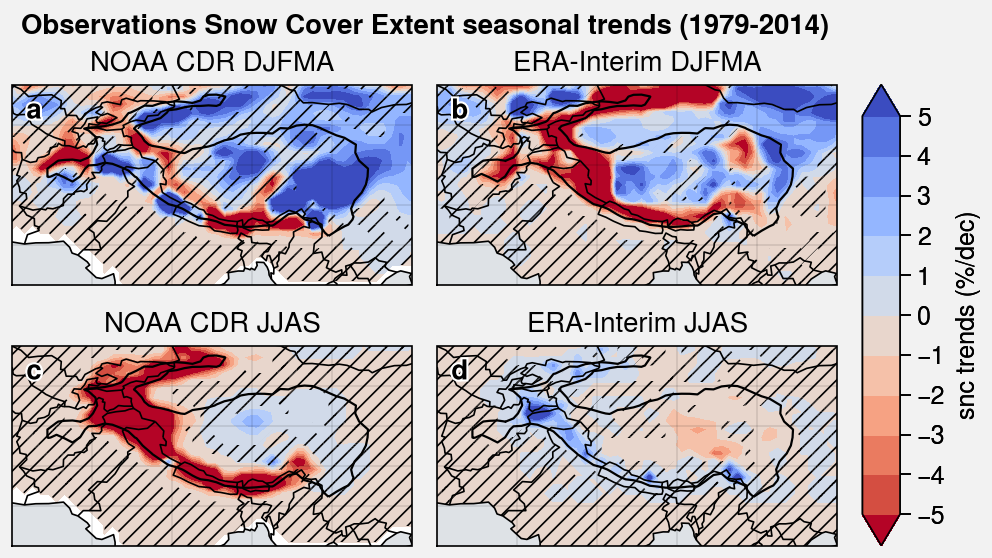

In [23]:
ym_obs_list = [ym_obs_snc, ym_obs_snc_erai]
title_list = ['NOAA CDR', 'ERA-Interim']*len(seasons)

cmap_list = ['ColdHot', 'CoolWarm_r', 'DryWet']
# cmap_list = ['RdYlBu', 'RdBu_r', 'DryWet']
levels_list = [plot.arange(-0.6,0.6,0.1), plot.arange(-5,5,1), plot.arange(-0.5,0.5,0.1)]
extend_list = ['both', 'both', 'both']

f, axs = plot.subplots(proj='cyl', ncols=len(ym_obs_list), nrows=len(seasons), axwidth=2)

k = 0
var = 'snc'
    
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

for season in seasons:
    for ym_obs in ym_obs_list:
        m = axs[k].contourf(
            ym_obs.sel(season=season).slope*10, cmap=cmap_list[1], levels=levels_list[1], extend=extend_list[1]
        )
        pvalue = ym_obs.sel(season=season).pvalue
        axs[k].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
        axs[k].format(title=title_list[k] + ' ' + season)
        k += 1

f.colorbar(m, label=var+' trends ('+units+'/dec)')
    
for ax in axs:
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

axs.format(
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Observations '+label+' seasonal trends ('+period.start+'-'+period.stop+')',
    abc=True, abcloc='ul'
)

filename = 'figS4_snc_obs_seasonal-trends_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

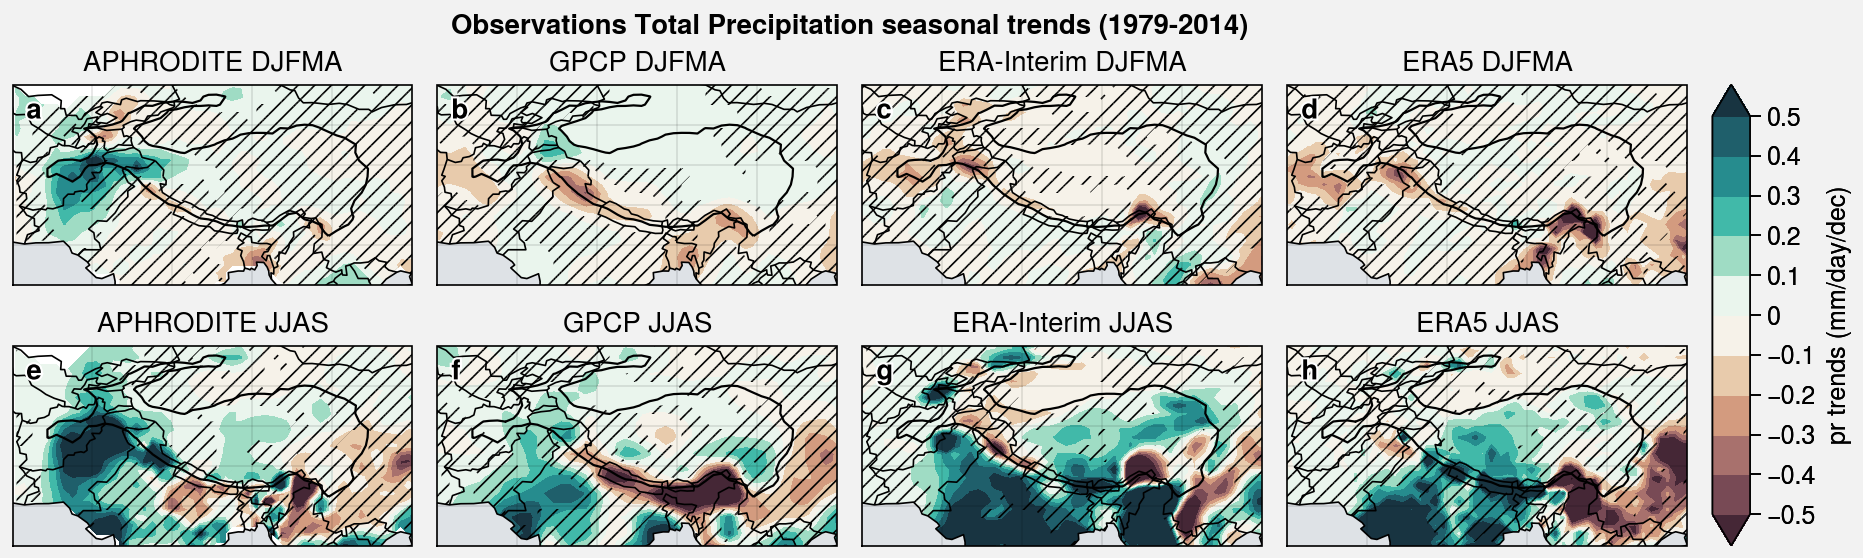

In [24]:
ym_obs_list = [ym_obs_pr, ym_obs_pr_GPCP, ym_obs_pr_erai, ym_obs_pr_era5]
title_list = ['APHRODITE', 'GPCP', 'ERA-Interim', 'ERA5']*len(seasons)

cmap_list = ['ColdHot', 'CoolWarm_r', 'DryWet']
# cmap_list = ['RdYlBu', 'RdBu_r', 'DryWet']
levels_list = [plot.arange(-0.6,0.6,0.1), plot.arange(-5,5,1), plot.arange(-0.5,0.5,0.1)]
extend_list = ['both', 'both', 'both']

f, axs = plot.subplots(proj='cyl', ncols=len(ym_obs_list), nrows=len(seasons), axwidth=2)

k = 0
var = 'pr'
    
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

for season in seasons:
    for ym_obs in ym_obs_list:
        m = axs[k].contourf(
            ym_obs.sel(season=season).slope*10, cmap=cmap_list[2], levels=levels_list[2], extend=extend_list[2]
        )
        pvalue = ym_obs.sel(season=season).pvalue
        axs[k].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
        axs[k].format(title=title_list[k] + ' ' + season)
        k += 1

f.colorbar(m, label=var+' trends ('+units+'/dec)')
    
for ax in axs:
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

axs.format(
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Observations '+label+' seasonal trends ('+period.start+'-'+period.stop+')',
    abc=True, abcloc='ul'
)

filename = 'figS5_pr_obs_seasonal-trends_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

# Bias versus trends

In [36]:
ym_obs_tas_erai[0]

<xarray.DataArray (year: 36, lat: 35, lon: 60)>
array([[[ 24.74294201,  24.64564554,  24.59258993, ...,  24.65647768,
          24.69777599,  24.79858037],
        [ 24.49960628,  24.54426595,  24.4462212 , ...,  24.18229816,
          24.2289232 ,  24.266508  ],
        [ 24.14240426,  24.30623024,  24.34420897, ...,  23.72953997,
          23.72924443,  23.73809774],
        ...,
        [ -5.99626822,  -6.4448702 ,  -6.93645517, ..., -14.40630541,
         -13.7175043 , -13.15647567],
        [ -7.05283095,  -7.55503946,  -8.05710742, ..., -13.82047974,
         -13.22146657, -13.38786226],
        [ -7.84673851,  -8.39538193,  -9.01273727, ..., -13.68341356,
         -13.39363329, -13.81824142]],

       [[ 24.89834494,  24.75947904,  24.6901237 , ...,  24.65256162,
          24.72778927,  24.85809245],
        [ 24.67622466,  24.67358297,  24.54348411, ...,  24.20995023,
          24.27906203,  24.34791292],
        [ 24.20015732,  24.52978031,  24.51281617, ...,  23.81108811,
          23.81831855,  23.8419242 ],
...
        [ -4.19857546,  -4.93234253,  -5.2826047 , ...,  -9.95586107,
          -9.55967136,  -8.96842542],
        [ -5.38214051,  -6.07820099,  -6.48412075, ..., -10.88311586,
          -9.99796341,  -9.49652423],
        [ -6.25216351,  -6.82262072,  -7.45939586, ..., -10.88001691,
         -10.35252431,  -9.8393005 ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
    surface    int64 0
    number     int64 0
    step       timedelta64[ns] 00:00:00
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014
  * lat        (lat) float32 15.5 16.5 17.5 18.5 19.5 ... 46.5 47.5 48.5 49.5
  * lon        (lon) float32 55.5 56.5 57.5 58.5 ... 111.5 112.5 113.5 114.5
    slope      (lat, lon) float64 0.01031 0.01053 0.01099 ... -0.00845 -0.01409
    intercept  (lat, lon) float64 4.414 3.878 2.92 3.039 ... -8.52 4.781 16.12
    rvalue     (lat, lon) float64 0.3072 0.3139 0.3394 ... -0.05225 -0.0845
    pvalue     (lat, lon) float64 0.07262 0.06632 0.04609 ... 0.7656 0.6293
    stderr     (lat, lon) float64 0.00556 0.005546 0.005304 ... 0.02811 0.02893
    season     <U5 'DJFMA'
Attributes:
    regrid_method:  bilinear

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of emp

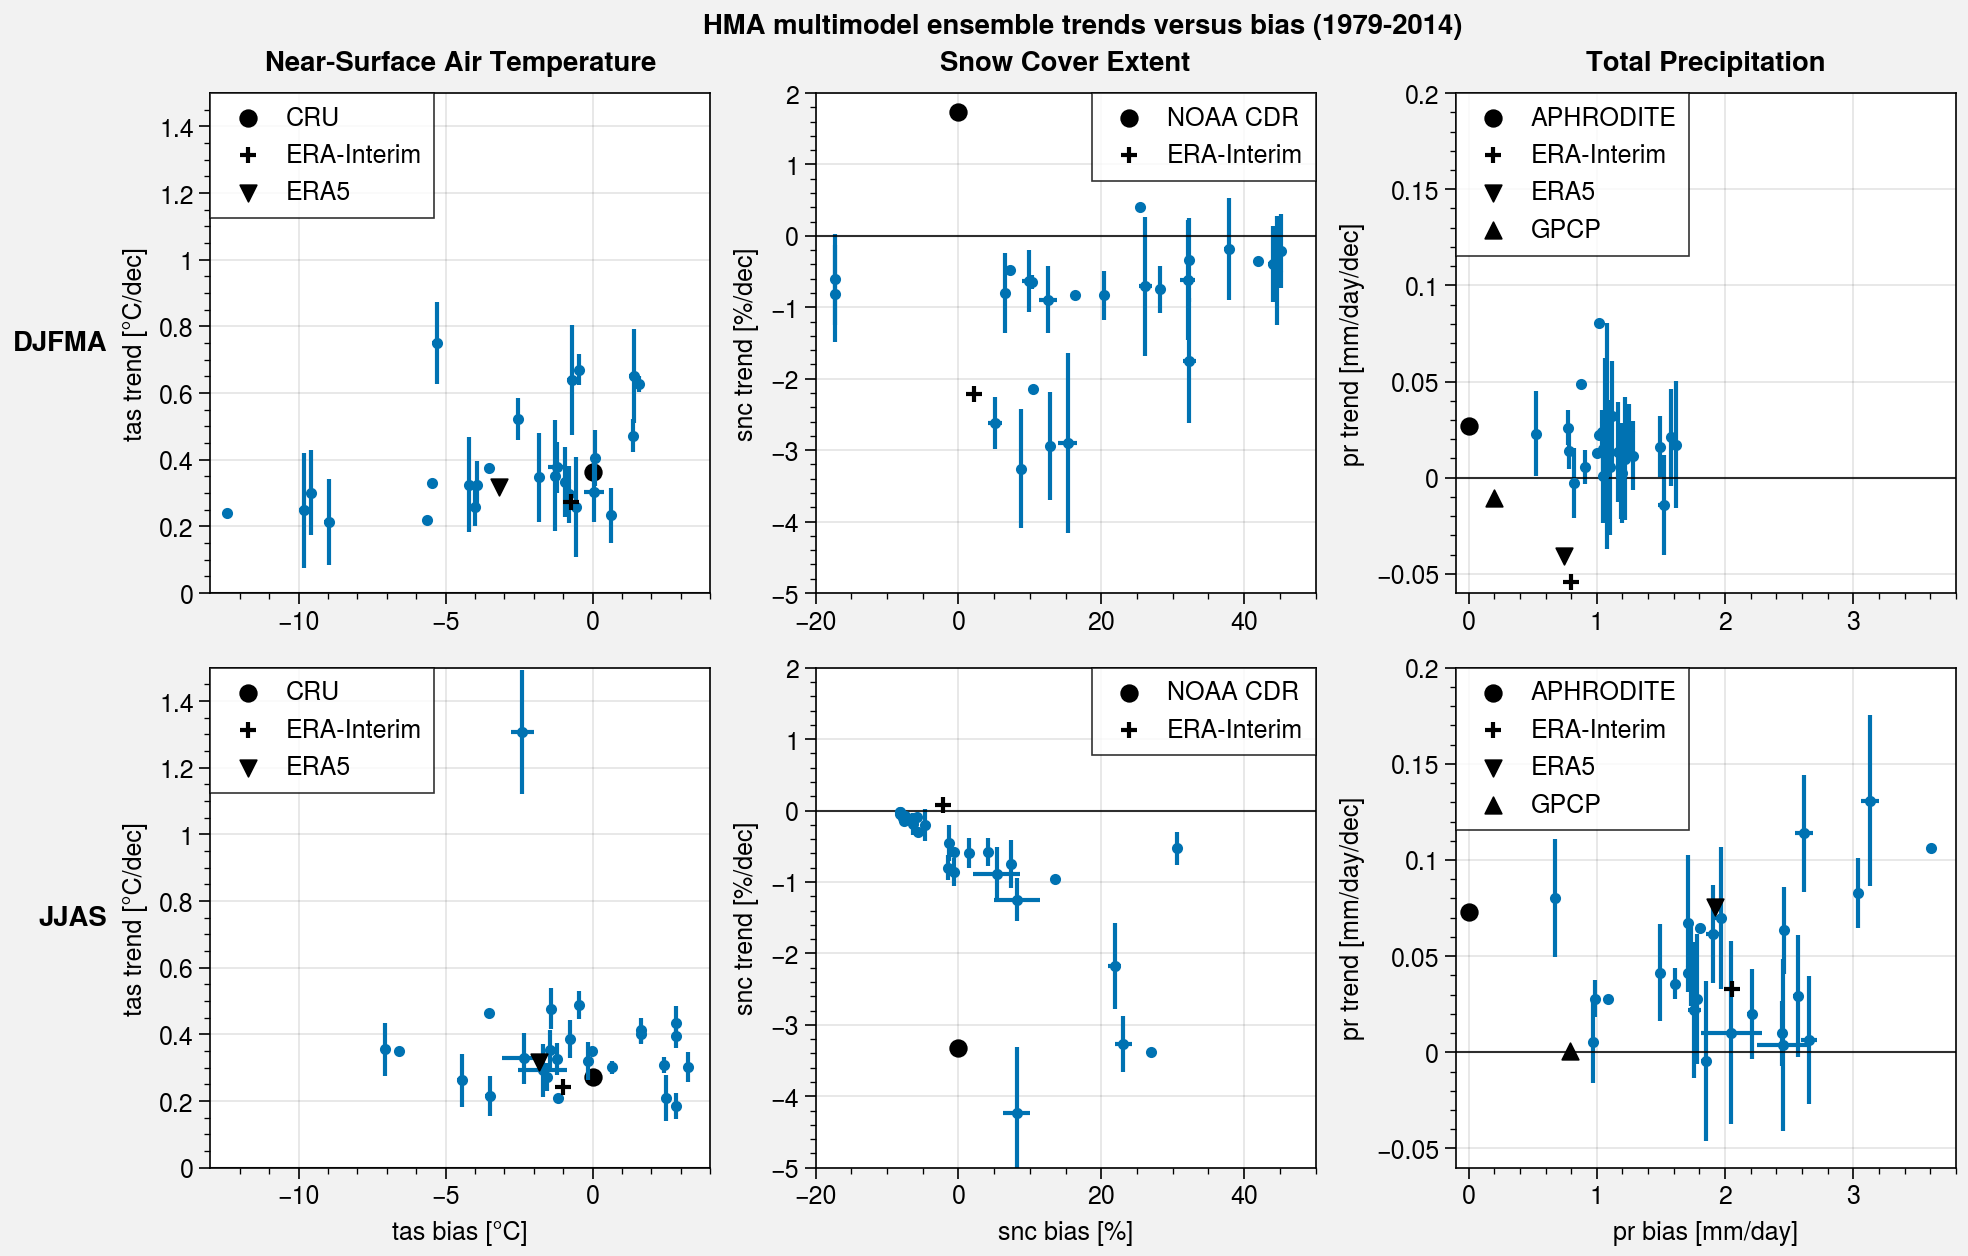

In [49]:
ym_obs_list = [ym_obs_tas, ym_obs_snc, ym_obs_pr]
obs_labels = ['CRU', 'NOAA CDR', 'APHRODITE']
xlims = [(-13, 4), (-20, 50), (-0.1, 3.8)]
ylims = [(0, 1.5), (-5, 2), (-0.06, 0.2)]
locs = ['ul', 'ur', 'ul']

fig, axs = plot.subplots(ncols=len(list_var), nrows=len(seasons), share=0)

zone = 'HMA'
k=0
for season in seasons[:]:
    for i_var, var in enumerate(list_var):
        
        h = []
        
        label, units, levels, cmap, extend, \
            levels_diff, cmap_diff, extend_diff, \
            levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
        
        for i_model, model in enumerate(list_models[:]):
            ym = ym_list[i_var][i_model].copy()

            # Check if values are not nan
            for realization in ym.slope.realization.values:
                if np.isnan(ym.slope[0].sel(realization=realization).mean()):
                    ym = ym.drop_sel(realization=realization)

            
            # models
            slope = u.spatial_average(
                ym.slope.sel(
                    lat=zones_df.loc[zone, 'latlim'], 
                    lon=zones_df.loc[zone, 'lonlim']
                ).where(elevation > 2500)
            )

            bias = u.spatial_average(
                ym.bias.sel(
                    lat=zones_df.loc[zone, 'latlim'], 
                    lon=zones_df.loc[zone, 'lonlim']
                ).where(elevation > 2500)
            )


            axs[k].errorbar(
                bias.sel(season=season).mean('realization'),
                (slope.sel(season=season)*10).mean('realization'), 
                yerr=(slope.sel(season=season)*10).std('realization'), 
                xerr=bias.sel(season=season).std('realization'),
                fmt='.C0'
            )
            
        # obs
        slope = u.spatial_average(
            ym_obs_list[i_var].slope.sel(
                lat=zones_df.loc[zone, 'latlim'], 
                lon=zones_df.loc[zone, 'lonlim']
            ).where(elevation > 2500)
        )

        h1 = axs[k].scatter(
            0, (slope.sel(season=season)*10),
            marker='o', color='k', label=obs_labels[i_var]
        )
        
        h.append(h1)
        
        # Other obs
        if var == 'tas':
            other_obs_labels = ['ERA-Interim', 'ERA5']
            markers = ['+', 'v']
            for i_obs, obs in enumerate([ym_obs_tas_erai, ym_obs_tas_era5]):
                slope = u.spatial_average(
                    obs.slope.sel(
                        lat=zones_df.loc[zone, 'latlim'], 
                        lon=zones_df.loc[zone, 'lonlim']
                    ).where(elevation > 2500)
                )
                
                bias = u.spatial_average(obs.mean('year').sel(lat=zones_df.loc[zone, 'latlim'], lon=zones_df.loc[zone, 'lonlim']).where(elevation > 2500)) \
                    - u.spatial_average(ym_obs_list[i_var].mean('year').sel(lat=zones_df.loc[zone, 'latlim'], lon=zones_df.loc[zone, 'lonlim']).where(elevation > 2500))

                h2 = axs[k].scatter(
                    bias.sel(season=season), (slope.sel(season=season)*10),
                    marker=markers[i_obs], color='k', label=other_obs_labels[i_obs], zorder=10
                )
                
                h.append(h2)
                
        elif var == 'snc':
            other_obs_labels = ['ERA-Interim']
            markers = ['+']
            for i_obs, obs in enumerate([ym_obs_snc_erai]):
                slope = u.spatial_average(
                    obs.slope.sel(
                        lat=zones_df.loc[zone, 'latlim'], 
                        lon=zones_df.loc[zone, 'lonlim']
                    ).where(elevation > 2500)
                )
                
                bias = u.spatial_average(obs.mean('year').sel(lat=zones_df.loc[zone, 'latlim'], lon=zones_df.loc[zone, 'lonlim']).where(elevation > 2500)) \
                    - u.spatial_average(ym_obs_list[i_var].mean('year').sel(lat=zones_df.loc[zone, 'latlim'], lon=zones_df.loc[zone, 'lonlim']).where(elevation > 2500))

                h2 = axs[k].scatter(
                    bias.sel(season=season), (slope.sel(season=season)*10),
                    marker=markers[i_obs], color='k', label=other_obs_labels[i_obs], zorder=10
                )
                
                h.append(h2)
                
        elif var == 'pr':
            other_obs_labels = ['ERA-Interim', 'ERA5', 'GPCP']
            markers = ['+', 'v', '^']
            for i_obs, obs in enumerate([ym_obs_pr_erai, ym_obs_pr_era5, ym_obs_pr_GPCP]):
                slope = u.spatial_average(
                    obs.slope.sel(
                        lat=zones_df.loc[zone, 'latlim'], 
                        lon=zones_df.loc[zone, 'lonlim']
                    ).where(elevation > 2500)
                )
                
                bias = u.spatial_average(obs.mean('year').sel(lat=zones_df.loc[zone, 'latlim'], lon=zones_df.loc[zone, 'lonlim']).where(elevation > 2500)) \
                    - u.spatial_average(ym_obs_list[i_var].mean('year').sel(lat=zones_df.loc[zone, 'latlim'], lon=zones_df.loc[zone, 'lonlim']).where(elevation > 2500))

                h2 = axs[k].scatter(
                    bias.sel(season=season), (slope.sel(season=season)*10),
                    marker=markers[i_obs], color='k', label=other_obs_labels[i_obs], zorder=10
                )
                
                h.append(h2)
        
        axs[k].plot(xlims[i_var], [0, 0], 'k', linewidth=0.75, alpha=0.8)
        
        if k in range(len(list_var)):
            axs[k].format(
                xlabel='',
                ylabel=var + ' trend ['+units+'/dec]',
                xlim=xlims[i_var], ylim=ylims[i_var]
            ) 
        else:   
            axs[k].format(
                xlabel=var + ' bias ['+units+']',
                ylabel=var + ' trend ['+units+'/dec]',
                xlim=xlims[i_var], ylim=ylims[i_var]
            )   
            
        axs[k].legend(h, frame=True, ncols=1, loc=locs[i_var])
            
        k += 1

axs.format(
    suptitle='HMA multimodel ensemble trends versus bias ('+period.start+'-'+period.stop+')',
    collabels=['Near-Surface Air Temperature', 'Snow Cover Extent', 'Total Precipitation'],
    rowlabels=seasons,
)

filename = 'fig7_trends-vs-bias_'+period.start+'-'+period.stop
# fig.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')